# Calculating line bisector from LSD profiles and individual lines


Line bisectors can be useful to study line asymmetries induced by photospheric convection. One of such examples is the convective blueshift, caused by the imbalance in surface coverage between hot granulues (rising material) and cooler intergranular lanes (downflow material). In this tutorial, we explore how the bisector function <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bis'>`calc_bis`</a>, part of the <a href='../API/LSD_API.html#specpolFlow.LSD'>`LSD`</a> class, can be used to analyse LSD profiles and individual lines as well. 

First import `specpolFlow` and any other packages.

In [1]:
import matplotlib.pyplot as plt
import specpolFlow as pol
import numpy as np

## Computing bisectors on LSD profiles
For our first example, we provide an LSD profile ([SampleLSD.lsd](https://github.com/folsomcp/specpolFlow/blob/main/docs-jb/Tutorials/CalculateBz_tutorialfiles/SampleLSD.lsd)) to illustrate the use of bisectors. First, we load the LSD profile, shift it to the stellar reference frame, and adjust the continuum normalization. 

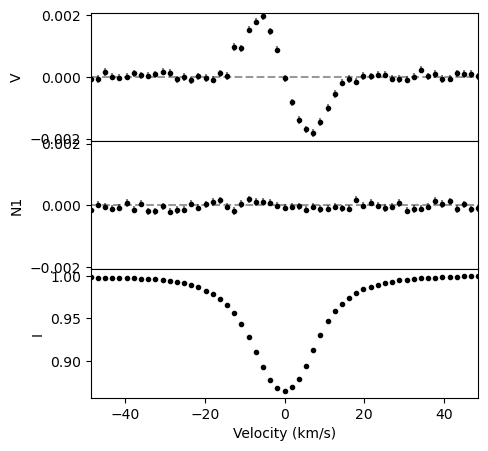

In [2]:
# read the LSD profile
lsd = pol.read_lsd("CalculateBz_tutorialfiles/SampleLSD.lsd")
# estimating the systemic velocity using the center of 
# gravity of Stokes I
cog = lsd.cog_I() 
# Doppler shift the profile 
lsd = lsd.vshift(cog)
# continuum normalization
lsd = lsd.norm(np.mean(lsd.specI[(lsd.vel < -50.0) | (lsd.vel > 50.0)]))
# slice profile to select a smaller window
lsd = lsd[np.abs(lsd.vel) < 50.0]
fig, ax = lsd.plot(figsize = (5,5))

We use the `calc_bis` function to compute the line bisector and velocity span following the definition of [Gray (1982)](https://ui.adsabs.harvard.edu/abs/1982ApJ...255..200G/abstract) and [Queloz et al. (2001)](https://www.aanda.org/component/article?access=bibcode&bibcode=&bibcode=2001A%2526A...379..279QFUL), respectively. The `bzwidth` keyword specifies the velocity range around the `cog` (i.e. relative to the line center) that will then be used to compute the bisector. Other possible kwargs are `plotFit` and `fullOutput`.


::::{margin}
:::{note}
The velocity span is the difference from the average velocity at the top and bottom part of the line bisector; this can be viewed as an estimation of the mean slope of the bisector.
:::
::::

By default, `fullOutput = False` and only the velocity span is returned. One can also set `fullOutput = True` to return:
- velocity span
- top velocity (i.e., within 10–40 per cent of the full line depth)
- bottom velocity (i.e., within 60–90 per cent of the full line depth)
- line bisector array
- intensity levels at which bisectors were computed

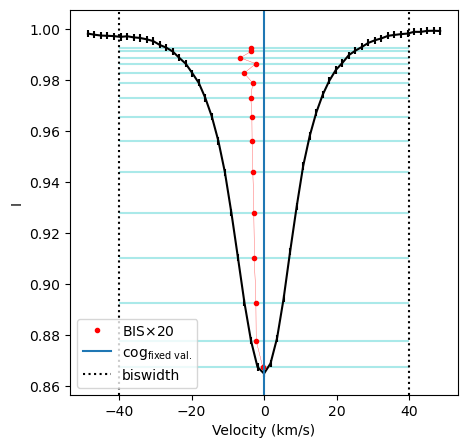

Velocity span = -0.054 km/s


In [3]:
# compute the line bisector in a 40 km/s window around cog
biswidth = 40 

# Get the velocity span and plot the line bisector
vspan = lsd.calc_bis(cog = 0, Ic = 1., biswidth = biswidth, fullOutput = False, plotFit = True)

print("Velocity span = %1.3f km/s" %(vspan))

The figure above shows a few useful things:
- vertical blue line shows the cog used as the line center
- black dotted line shows the velocity width used to compute the bisector
- horizontal cyan lines in the figure represent the intensity levels used to compute the line bisector - Note that the line profile must be interpolated at the left and right intersections with these levels to compute the bisector
- red line illustrates the line bisector scaled up by a factor for illustration purposes. 


:::{Warning}
 It is important to adequately set the continuum level `Ic` as the bisector function uses that value as a reference to estimate the velocity span. 
:::

## Computing bisectors on individual line profiles

The following example demonstrates how to use bisectors on individual spectral lines. We analyze the spectrum of the main-sequence star 51 Peg, the first star where an exoplanet was detected. Although not covered in this tutorial, bisectors are a valuable tool for determining if radial velocity variations are due to an orbiting planet. As the planet reflex motion should only shift the line bisector without modifying its curvature, correlations between the velocity span and the radial velocity help dismiss a planet candidate.

In [4]:
# reading the spectrum
spec = pol.read_spectrum("CalculateBisector_tutorialfiles/1604052pu.s.norm")

First create individual line profiles for a couple of iron, sodium and hidrogen lines.  

In [5]:
# defining the line parameters
line_ref = ['Fe I','Fe I','Fe I','Fe I','Na I','Fe I', 'Ha'] # 
lambda0 = [538.337, 539.318, 539.713, 543.45232, 589.592424, 630.24932,656.281] 

# center of gravity from literature 
cog = -33.129 

# compute the line bisector in a biswidth km/s window around cog
biswidth = [20, 20, 20, 20,40, 10, 45]

prof = []
# Loop over each line
for il0, ibiswidth in zip(lambda0,biswidth):
    lwidth = 150. * il0 / 2.99e5 #width in nm from width in km/s

    # getting the profile for that line
    iprof = spec.individual_line(il0, lwidth=lwidth)

    # chaging to the stellar reference frame 
    # estimates the systemic velocity from the cog of line core 
    iprof = iprof.vshift(cog)

    # Slice the profile in a 2*ibiswidth km/s window around cog
    iUseVelRange = np.abs(iprof.vel) < 2*ibiswidth
    iprof = iprof[iUseVelRange]

    # normalize the profile for the bisector computation
    Ic = np.mean(iprof.specI[np.abs(iprof.vel) > ibiswidth])
    iprof = iprof.norm(Ic)
    prof.append(iprof)

We provied a list of `biswidth` in the example above. These values were chosen after inspecting each of the selected lines. Remember to carefully select this parameter when running a similar analysis, as wiggles around the continuum might confuse the bisector function. By construction, the bisector function attempts to prevent that issue by removing 5% of the line profile near the continuum from the line bisector calculation.

We can now loop over the individual line profiles and call the <a href='../API/LSD_API.html#specpolFlow.LSD.calc_bis'>`calc_bis`</a> function. The code below illustrates the line profiles computed for the list of individual lines defined above.

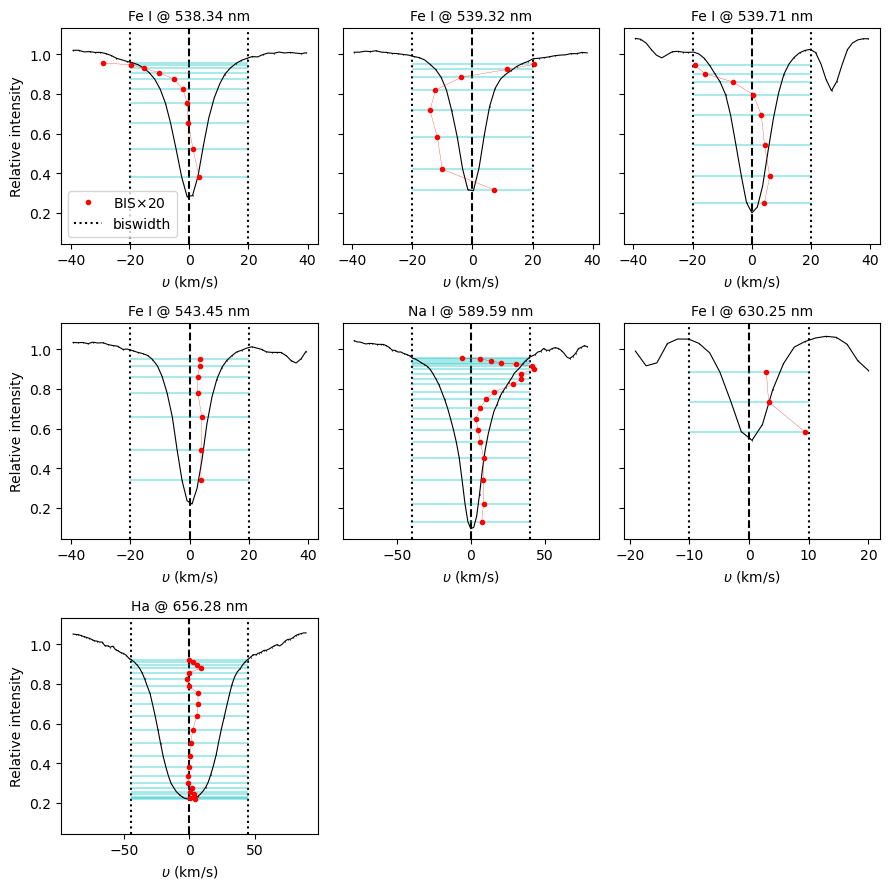

In [6]:
ncols = 3
nrows = int(np.ceil(len(lambda0)/ncols))

fig, grid = plt.subplots(nrows,ncols, figsize = (9,9), sharey = True)
axes = grid.flatten()

vspan = np.zeros(len(lambda0))
vtop = np.zeros(len(lambda0))
vbottom = np.zeros(len(lambda0))
for id in range(len(lambda0)):
    # Get the line bisector and velocity span. 
    # Note that fullOutput is set to true in this example.
    vspan[id], vtop[id], vbottom[id], bisector, intensity_levels = prof[id].calc_bis(cog = 0, Ic = 1, biswidth = biswidth[id], fullOutput = True, plotFit = False)

    #### Plot ###
    axes[id].errorbar(prof[id].vel, prof[id].specI, yerr = prof[id].specSigI, c = 'k', lw = 0.8, zorder = 1)
    scale_bisector = 20 # arbitrary scale
    axes[id].plot(bisector*scale_bisector, intensity_levels, 'r.', label = r'BIS$\times %d$' %scale_bisector, zorder = 2)
    axes[id].plot(bisector*scale_bisector, intensity_levels, 'r-', lw = 0.2, zorder = 2)
    axes[id].axvline(biswidth[id], c = 'k', ls = ':', label = 'biswidth', zorder = 0)
    axes[id].axvline(-biswidth[id], c = 'k', ls = ':', zorder = 0)
    axes[id].axvline(0, c = 'k', ls = '--', zorder = 0)
    axes[id].hlines(intensity_levels, xmin = -biswidth[id],xmax = biswidth[id], alpha = 1/3, color = 'c', zorder = 0)
    axes[id].set_title('%s @ %1.2f nm'%(line_ref[id],lambda0[id]), fontsize='medium')
    axes[id].set_xlabel(r'$\upsilon$ (km/s)', fontsize = 'medium')
    if id == 0:
        axes[id].legend()

for id in range(nrows):
    grid[id,0].set_ylabel(r'Relative intensity', fontsize = 'medium')

for id in range(len(lambda0),len(axes)):
    axes[id].set_axis_off()

plt.tight_layout()